# DR Binary Classification

In [1]:
import numpy as np
from skimage import exposure
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
import seaborn as sns
import random
import imgaug.augmenters as iaa
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB3

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,MaxPooling2D,BatchNormalization,Input,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import preprocessing
from skimage import exposure,filters,color

# from Preprocessing import *
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,roc_curve, roc_auc_score
import warnings 
warnings.filterwarnings('ignore')

2024-05-22 12:03:50.836293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 12:03:50.836390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 12:03:50.942873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Context

in  this notebook we are going to try some segmentations using unet 

<img src='https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs12938-020-00766-3/MediaObjects/12938_2020_766_Fig1_HTML.png?as=webp'>

* [No Segmentation](#ns)
* [Microaneurysms Segmentation](#ms)
* [Haemorrhages Segmentation](#hae)
* [Hard Exudates Segmentation](#hes)

# Pre-Processing Fonction

In [2]:
def preprocess_image(gray_image):
    
    # Ensure the input image is of the correct type for CLAHE
    if gray_image.dtype != np.uint8:
        gray_image = gray_image.astype(np.uint8)
        
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_limit_image = clahe.apply(gray_image)
    # Gamma correction
    gamma_corrected_image = cv2.convertScaleAbs(contrast_limit_image, alpha=1.2)
    # Gaussian filtering
    filtered_image = filters.gaussian(gamma_corrected_image, sigma=0.5)
    # Reshape the image to have a single channel
    processed_image = filtered_image.reshape(filtered_image.shape + (1,))

    return processed_image

# Augmentation Fonction

In [3]:
def augment_images(x_data):
    # Define augmentation pipeline
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),    # horizontally flip 50% of the images
        iaa.Affine(rotate=(-5, 5)),  # rotate images by -5 to +5 degrees
        iaa.Affine(shear=(-2, 2)),  # shear images by -2 to +20degrees
    ])
    # Augment each image in the list
    augmented_images = seq(images=x_data)
    return augmented_images

In [2]:
def split_data(x_train,y_train):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
    return x_train,y_train,x_val,y_val

# Models

In [3]:
def efficientnet_model(IMAGE_SIZE):
    
    efficientnet = EfficientNetB3(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)    
        
    input_shape = IMAGE_SIZE + (1,)    
    model_efficientnet = Sequential()
    model_efficientnet.add(Input(shape=input_shape))
    model_efficientnet.add(Conv2D(3, (3, 3), padding='same', activation='relu'))
    model_efficientnet.add(efficientnet)
    model_efficientnet.add(GlobalAveragePooling2D())
    model_efficientnet.add(Flatten())
    model_efficientnet.add(Dropout(0.2))
    model_efficientnet.add(Dense(512,activation='relu'))
    model_efficientnet.add(Dropout(0.2))
    model_efficientnet.add(Dense(1,activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001) 
    
    model_efficientnet.compile(
        optimizer = optimizer, 
        loss=losses.BinaryCrossentropy(from_logits=True), 
        metrics=['accuracy'])
    
    return model_efficientnet

<h1 id='ns'>1 - EfficientNet Training on Normal data</h1>

### Importing the data

In [6]:
train_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/train.csv')

x_train = []
y_train = []

image_size = (512, 512)

for index, row in train_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Original/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_train.append(image)
    y_train.append(row['diagnosis'])

x_train = np.array(x_train)
y_train = np.array(y_train, dtype=np.int32)

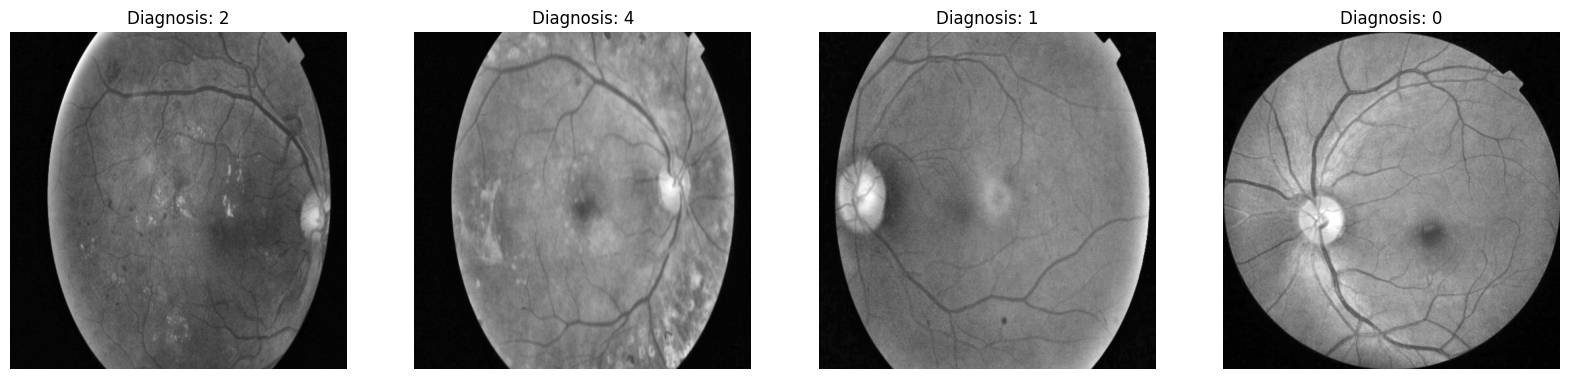

In [7]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title(f"Diagnosis: {y_train[i]}")
    plt.axis('off')
plt.show()

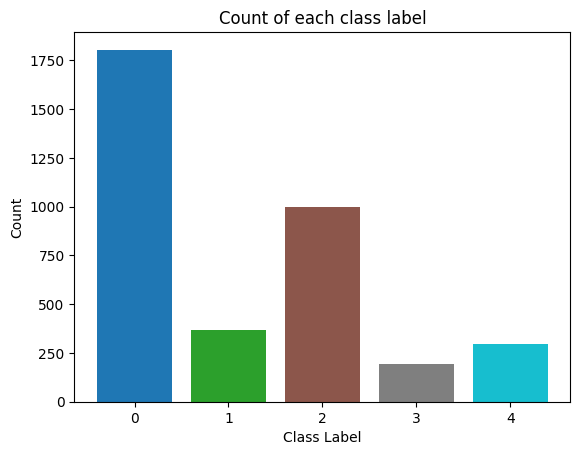

In [8]:
# Count the occurrences of each class label
unique_elements, counts = np.unique(train_df['diagnosis'], return_counts=True)

# Plot the counts
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_elements)))
plt.bar(unique_elements, counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of each class label')
plt.show()

In [9]:
test_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/test.csv')

x_test = []
y_test = []

for index, row in test_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Original/test_images/{row['id_code']}"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_test.append(image)
    y_test.append(row['diagnosis'])

x_test = np.array(x_test)
y_test = np.array(y_test, dtype=np.int32)

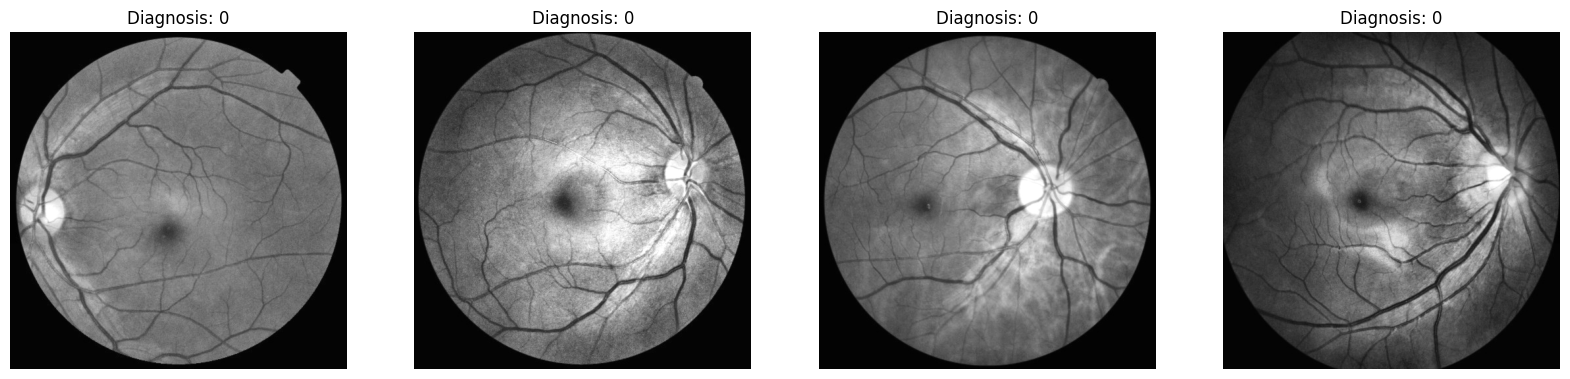

In [10]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_test[i],cmap='gray')
    plt.title(f"Diagnosis: {y_test[i]}")
    plt.axis('off')
plt.show()

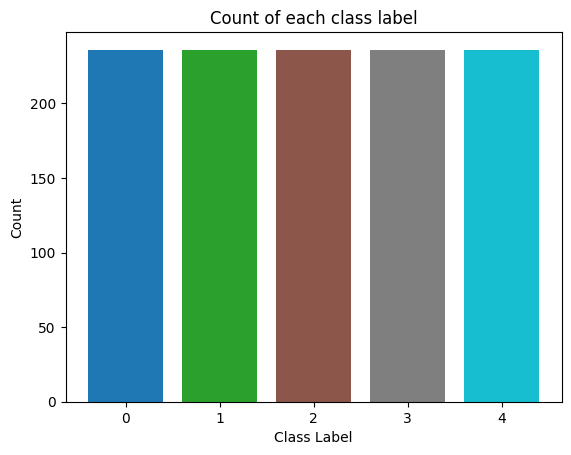

In [11]:
# Count the occurrences of each class label
unique_elements, counts = np.unique(test_df['diagnosis'], return_counts=True)

# Plot the counts
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_elements)))
plt.bar(unique_elements, counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of each class label')
plt.show()

### Converting the data into binary

In [12]:
y_train = np.where(y_train < 1, 0, 1)
y_test = np.where(y_test <= 1, 0, 1)

## Splitinto_categorical data

In [13]:
x_test.shape

(1180, 512, 512)

In [14]:
x_train,y_train,x_val, y_val = split_data(x_train,y_train)
print('done')
print(x_train.shape,x_val.shape)

done
(2929, 512, 512) (733, 512, 512)


## Data Image Grading

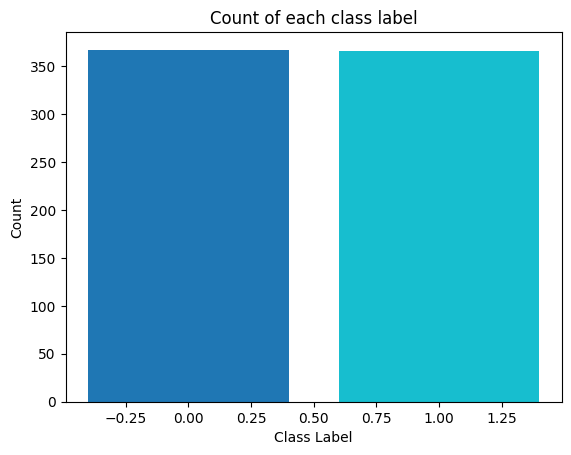

In [15]:
# Count the occurrences of each class label
unique_elements, counts = np.unique(y_val, return_counts=True)

# Plot the counts
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_elements)))
plt.bar(unique_elements, counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of each class label')
plt.show()

## Initialising

In [17]:
IMAGE_SIZE = (512,512)
EPOCHS = 25
BATCH_SIZE = 8
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('basic_model.keras', save_best_only=True, monitor='val_loss')

In [18]:
model_efficientnet_basic = efficientnet_model(IMAGE_SIZE)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [19]:
model_efficientnet_history =model_efficientnet_basic.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr,early_stopping,model_checkpoint]
)

Epoch 1/25


I0000 00:00:1716311853.011132     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716311853.174895     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8760 - loss: 0.3415

W0000 00:00:1716312039.935627     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 364s 551ms/step - accuracy: 0.8761 - loss: 0.3413 - val_accuracy: 0.5007 - val_loss: 1.6409 - learning_rate: 0.0010
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 279ms/step - accuracy: 0.9534 - loss: 0.1559 - val_accuracy: 0.8731 - val_loss: 0.4754 - learning_rate: 0.0010
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 279ms/step - accuracy: 0.9686 - loss: 0.1091 - val_accuracy: 0.8881 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 103s 280ms/step - accuracy: 0.9764 - loss: 0.0758 - val_accuracy: 0.9727 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 101s 275ms/step - accuracy: 0.9732 - loss: 0.0789 - val_accuracy: 0.8445 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 279ms/step - accuracy: 0.9788 - loss: 0.0644 - val_accuracy: 0.9905 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 101s 275ms/step - accuracy: 0.9800 

In [25]:
loss_efficientnet_basic, accuracy_efficientnet_basic = model_efficientnet_basic.evaluate(x_test,y_test)

print("Test Loss:", loss_efficientnet_basic)
print("Test Accuracy:", accuracy_efficientnet_basic)

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.8537 - loss: 0.5566
Test Loss: 0.8623356819152832
Test Accuracy: 0.7754237055778503


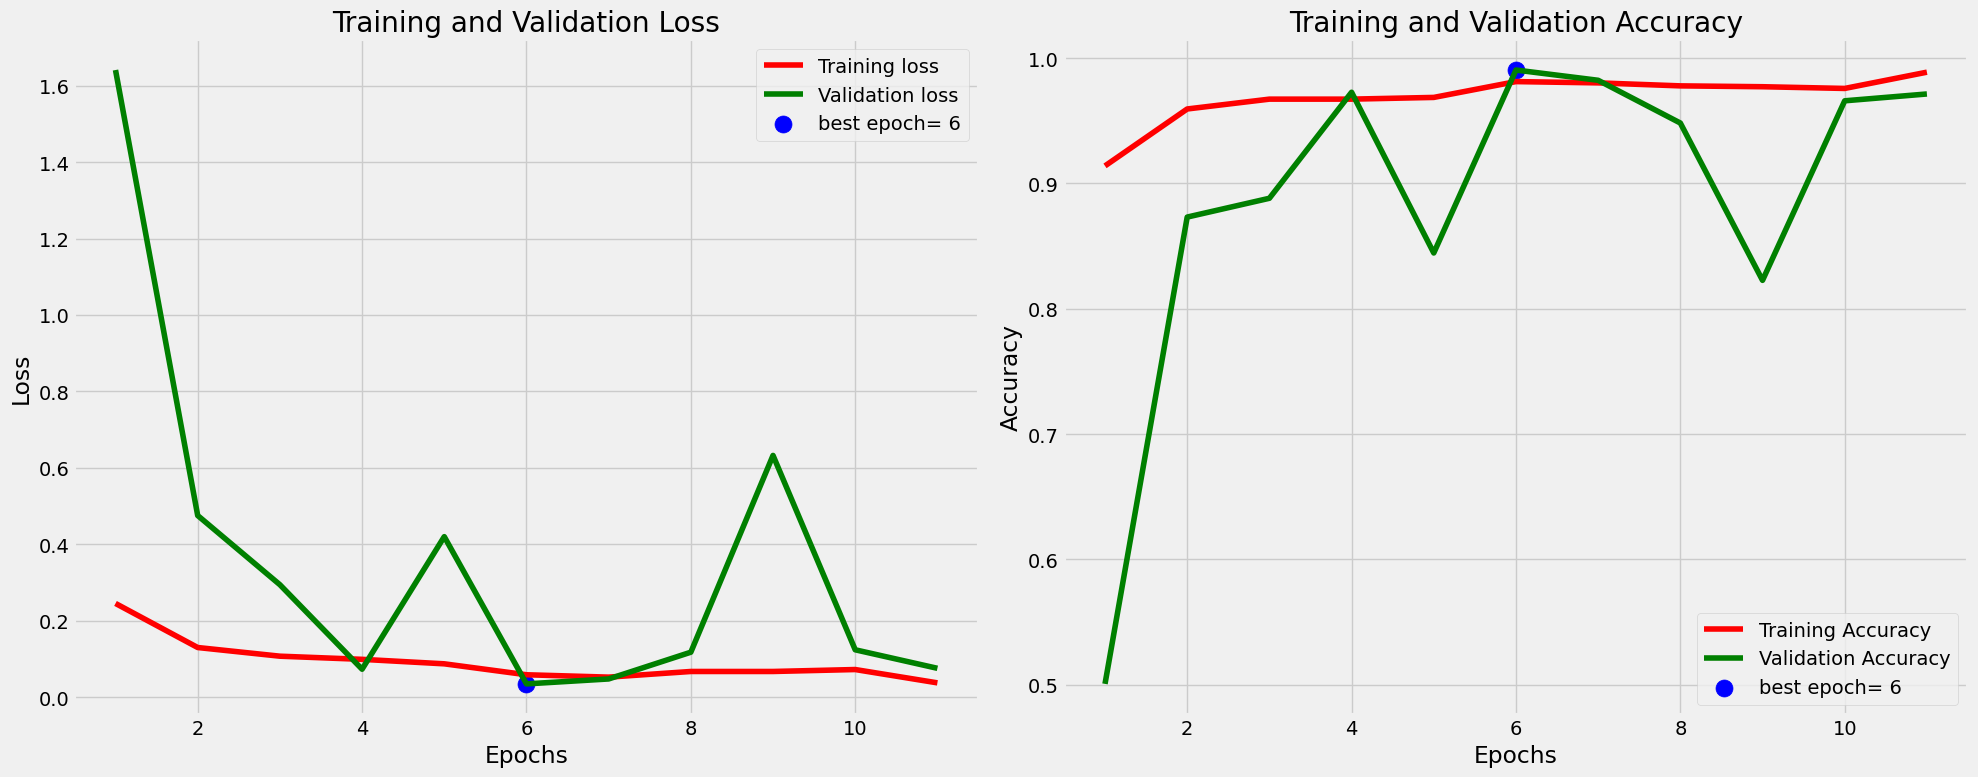

In [26]:
# Define needed variables
tr_acc = model_efficientnet_history.history['accuracy']
tr_loss = model_efficientnet_history.history['loss']
val_acc = model_efficientnet_history.history['val_accuracy']
val_loss = model_efficientnet_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step


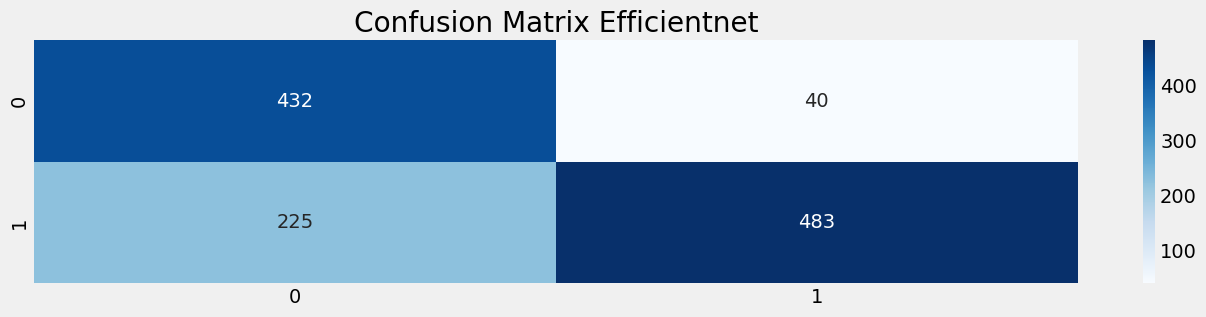

In [30]:
plt.figure(figsize=(15, 3))
y_pred_prob = model_efficientnet_basic.predict(x_test)
y_pred = np.round(y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Efficientnet')
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step


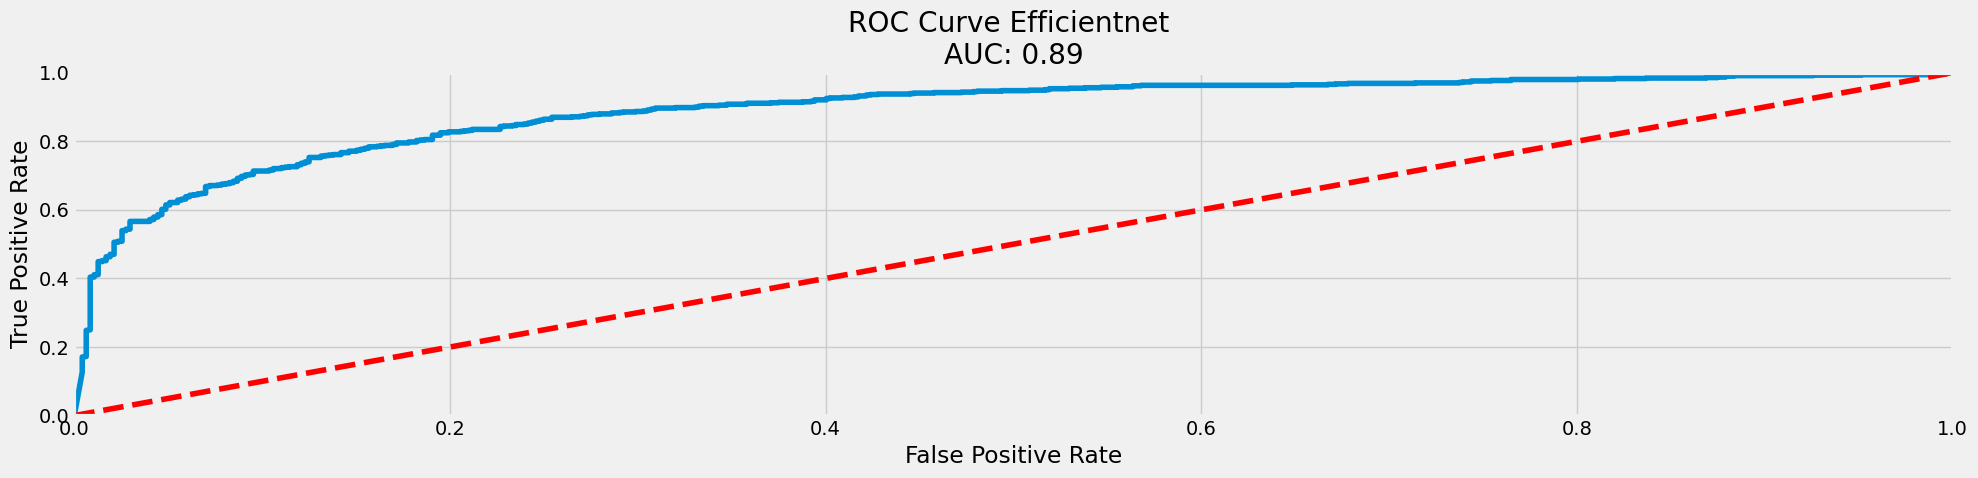

In [43]:
plt.figure(figsize=(20, 5))
y_pred_prob = model_efficientnet_basic.predict(x_test)
y_pred = np.round(y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  
plt.plot(fpr, tpr)
plt.title('ROC Curve Efficientnet \nAUC: {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


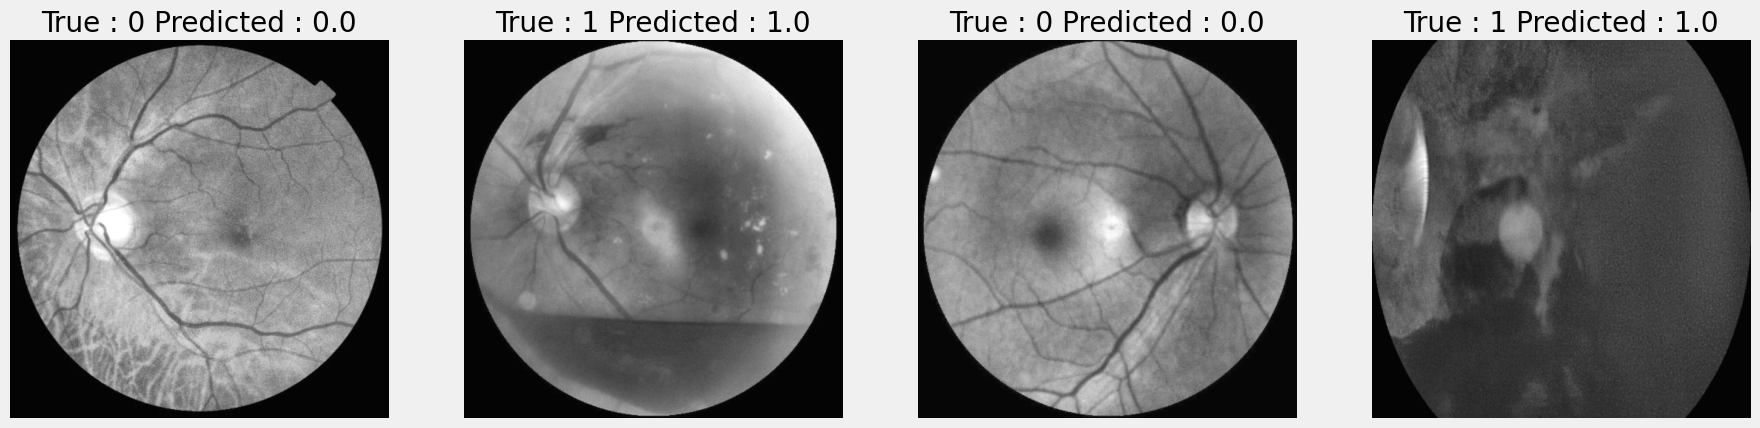

In [42]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    num = random.randint(0,x_test.shape[0])
    plt.imshow(x_test[num],cmap='gray')
    single_image = np.expand_dims(x_test[num], axis=0)
    y_pred = np.round(model_efficientnet_basic.predict(single_image)[0])
    plt.title(f"True : {y_test[num]} Predicted : {y_pred[0]}")
    plt.axis('off')
plt.show()

In [47]:
# model_efficientnet_basic.save_weights('basic_model.weights.h5')
# model_efficientnet_basic.load_weights('basic_model.weights.h5')

<h1 id='ms'>2 . Microaneurysm Segmentation</h1>

### Importing segmented data the data

In [4]:
train_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/train.csv')

x_train = []
y_train = []

image_size = (512, 512)

for index, row in train_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Microaneurysm/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_train.append(image)
    y_train.append(row['diagnosis'])

x_train = np.array(x_train)
y_train = np.array(y_train, dtype=np.int32)

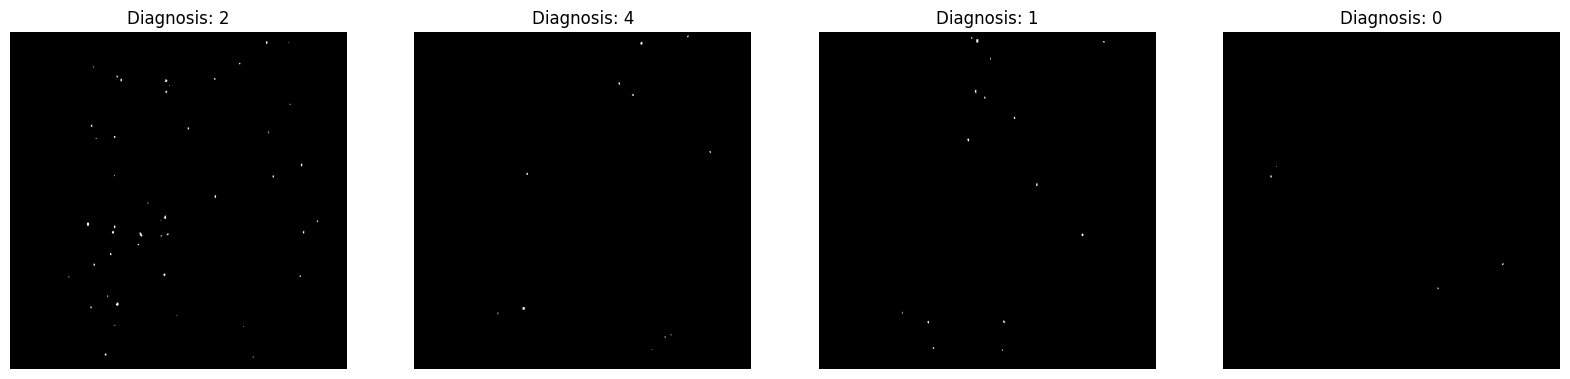

In [5]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title(f"Diagnosis: {y_train[i]}")
    plt.axis('off')
plt.show()

In [25]:
test_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/test.csv')

x_test = []
y_test = []

for index, row in test_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Microaneurysm/test_images/{row['id_code']}"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_test.append(image)
    y_test.append(row['diagnosis'])

x_test = np.array(x_test)
y_test = np.array(y_test, dtype=np.int32)

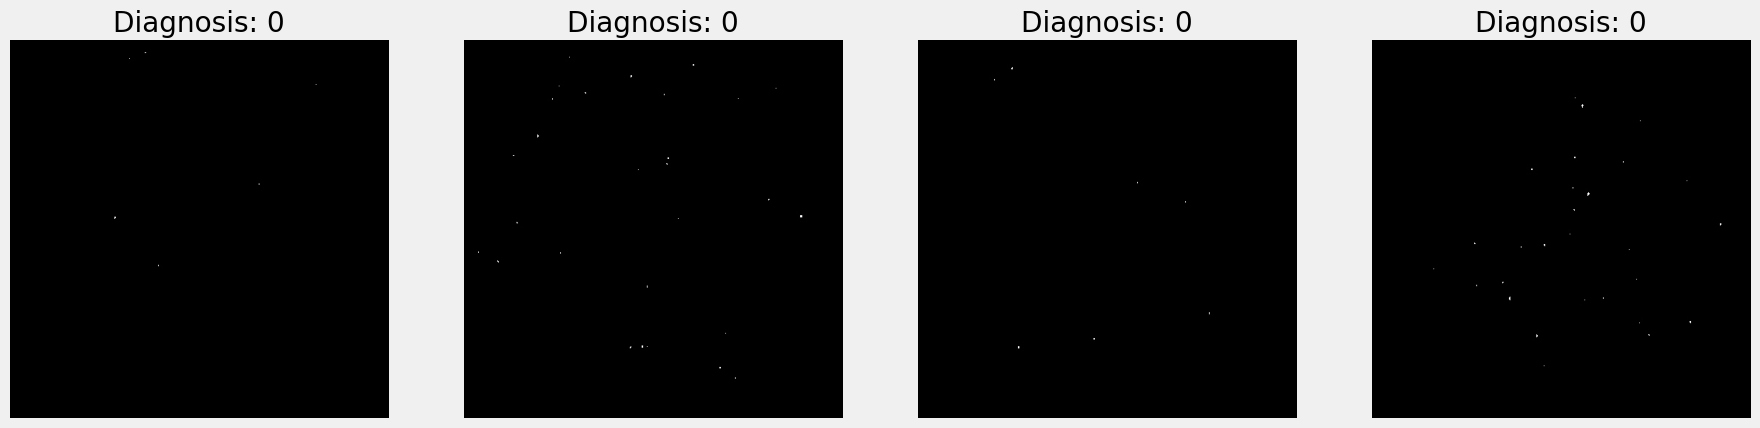

In [26]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_test[i],cmap='gray')
    plt.title(f"Diagnosis: {y_test[i]}")
    plt.axis('off')
plt.show()

In [27]:
y_train = np.where(y_train < 1, 0, 1)
y_test = np.where(y_test <= 1, 0, 1)

In [9]:
x_train,y_train,x_val, y_val = split_data(x_train,y_train)
print('done')
print(x_train.shape,x_val.shape)

done
(2929, 512, 512) (733, 512, 512)


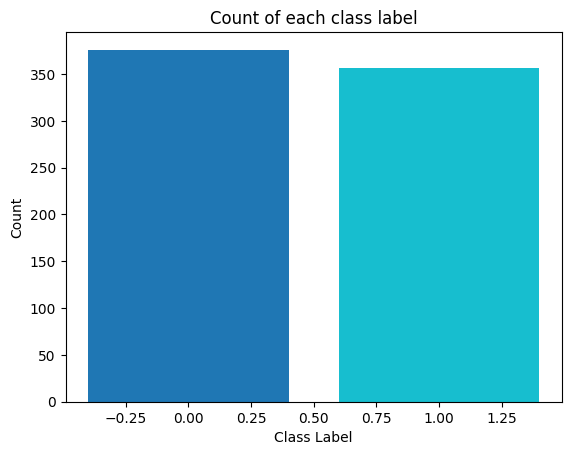

In [10]:
# Count the occurrences of each class label
unique_elements, counts = np.unique(y_val, return_counts=True)

# Plot the counts
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_elements)))
plt.bar(unique_elements, counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of each class label')
plt.show()

In [11]:
IMAGE_SIZE = (512,512)
EPOCHS = 25
BATCH_SIZE = 8
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('basic_model.keras', save_best_only=True, monitor='val_loss')

In [12]:
model_efficientnet_ms = efficientnet_model(IMAGE_SIZE)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model_efficientnet_ms_history =model_efficientnet_ms.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr,early_stopping,model_checkpoint]
)

Epoch 1/25


I0000 00:00:1716372169.817149     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716372169.986752     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8223 - loss: 0.4344

W0000 00:00:1716372367.058782     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 385s 581ms/step - accuracy: 0.8224 - loss: 0.4342 - val_accuracy: 0.5130 - val_loss: 0.8353 - learning_rate: 0.0010
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 273ms/step - accuracy: 0.9144 - loss: 0.2536 - val_accuracy: 0.5130 - val_loss: 2.2743 - learning_rate: 0.0010
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 278ms/step - accuracy: 0.9180 - loss: 0.2409 - val_accuracy: 0.7531 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 274ms/step - accuracy: 0.9323 - loss: 0.1984 - val_accuracy: 0.5130 - val_loss: 1.9413 - learning_rate: 0.0010
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 278ms/step - accuracy: 0.9144 - loss: 0.2440 - val_accuracy: 0.9359 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 274ms/step - accuracy: 0.9364 - loss: 0.1913 - val_accuracy: 0.8963 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 279ms/step - accuracy: 0.9444 

In [24]:
loss_efficientnet_ms, accuracy_efficientnet_ms = model_efficientnet_ms.evaluate(x_test, y_test)

print("Test Loss:", loss_efficientnet_ms)
print("Test Accuracy:", accuracy_efficientnet_ms)

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.6192 - loss: 1.0965
Test Loss: 1.495485544204712
Test Accuracy: 0.47033897042274475


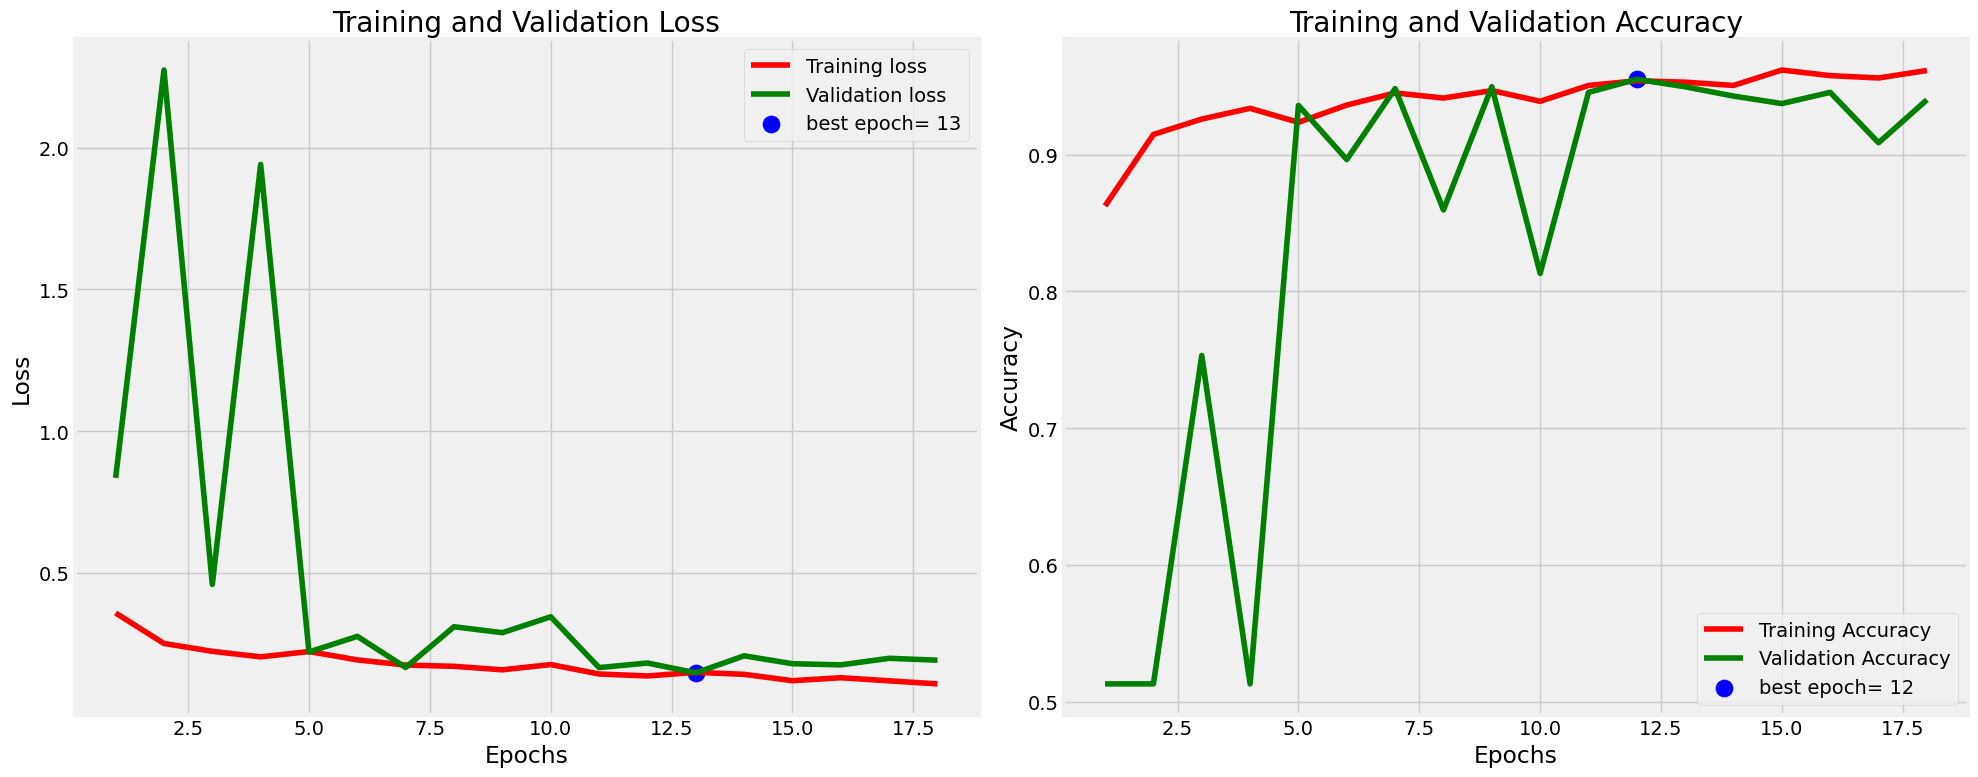

In [15]:
# Define needed variables
tr_acc = model_efficientnet_ms_history.history['accuracy']
tr_loss = model_efficientnet_ms_history.history['loss']
val_acc = model_efficientnet_ms_history.history['val_accuracy']
val_loss = model_efficientnet_ms_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 438ms/step


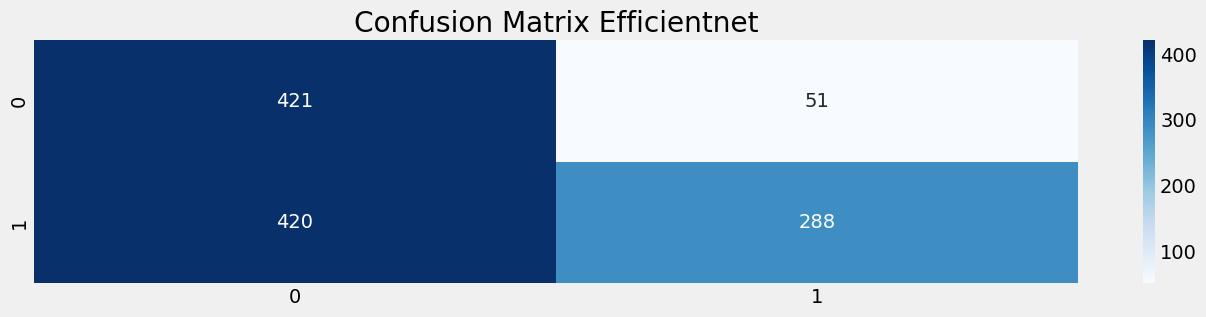

In [16]:
plt.figure(figsize=(15, 3))
y_pred_prob = model_efficientnet_ms.predict(x_test)
y_pred = np.round(y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Efficientnet')
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step


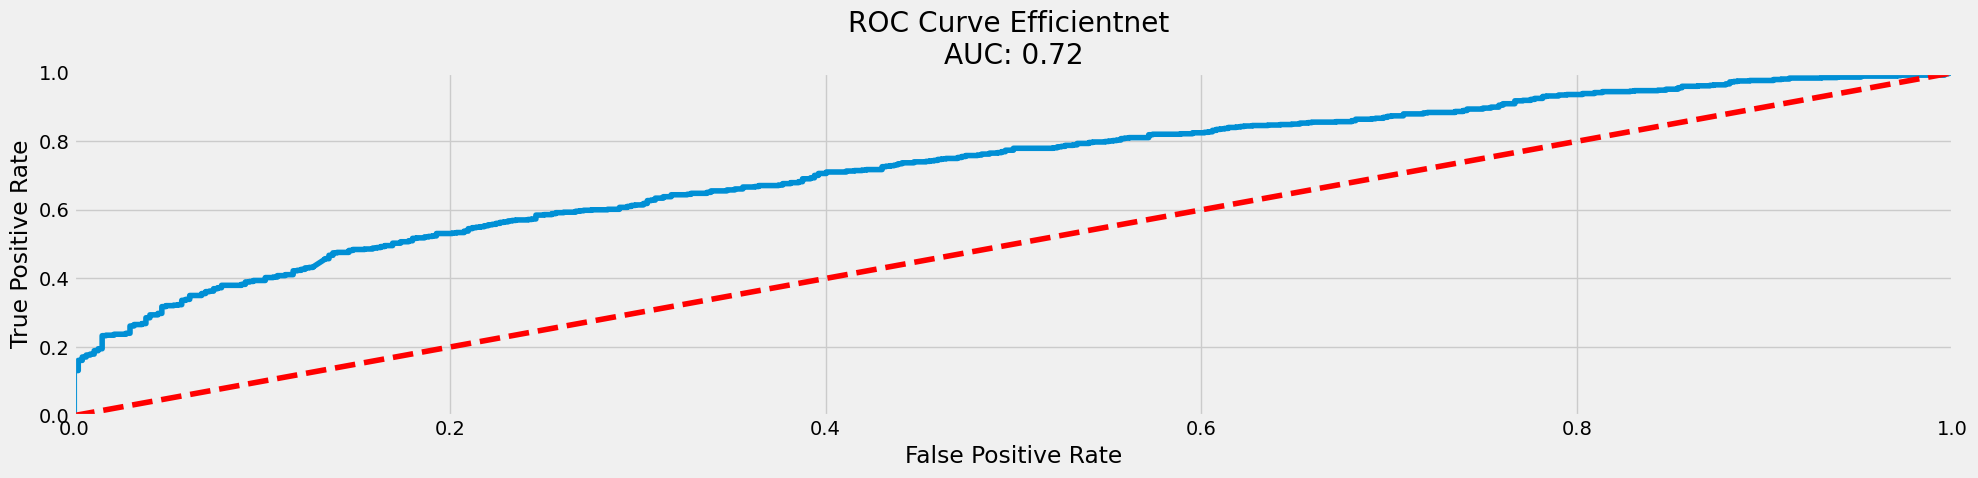

In [17]:
plt.figure(figsize=(20, 5))
y_pred_prob = model_efficientnet_ms.predict(x_test)
y_pred = np.round(y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  
plt.plot(fpr, tpr)
plt.title('ROC Curve Efficientnet \nAUC: {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


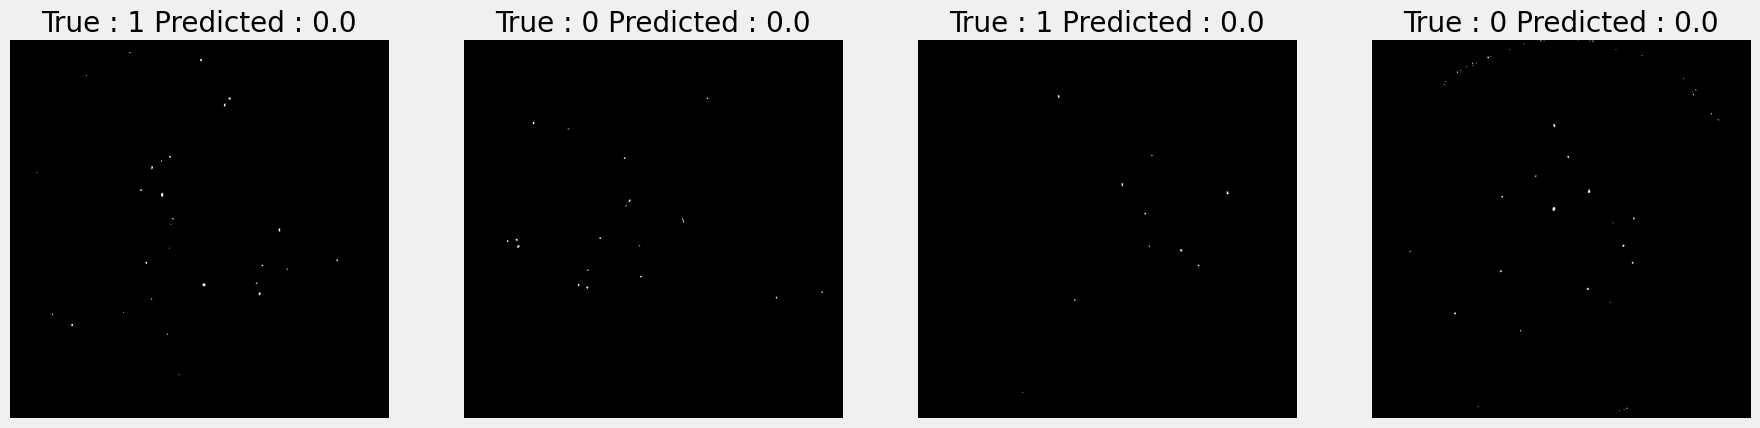

In [18]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    num = random.randint(0,x_test.shape[0])
    plt.imshow(x_test[num],cmap='gray')
    single_image = np.expand_dims(x_test[num], axis=0)
    y_pred = np.round(model_efficientnet_ms.predict(single_image)[0])
    plt.title(f"True : {y_test[num]} Predicted : {y_pred[0]}")
    plt.axis('off')
plt.show()

In [19]:
model_efficientnet_ms.save_weights('Microaneurysm_model.weights.h5')
# model_efficientnet_ms.load_weights('Microaneurysm_model.weights.h5')

<h1 id='hae'>Haemorrhages Segmentation</h1>

In [4]:
train_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/train.csv')

x_train = []
y_train = []

image_size = (512, 512)

for index, row in train_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Haemorrhages/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_train.append(image)
    y_train.append(row['diagnosis'])

x_train = np.array(x_train)
y_train = np.array(y_train, dtype=np.int32)

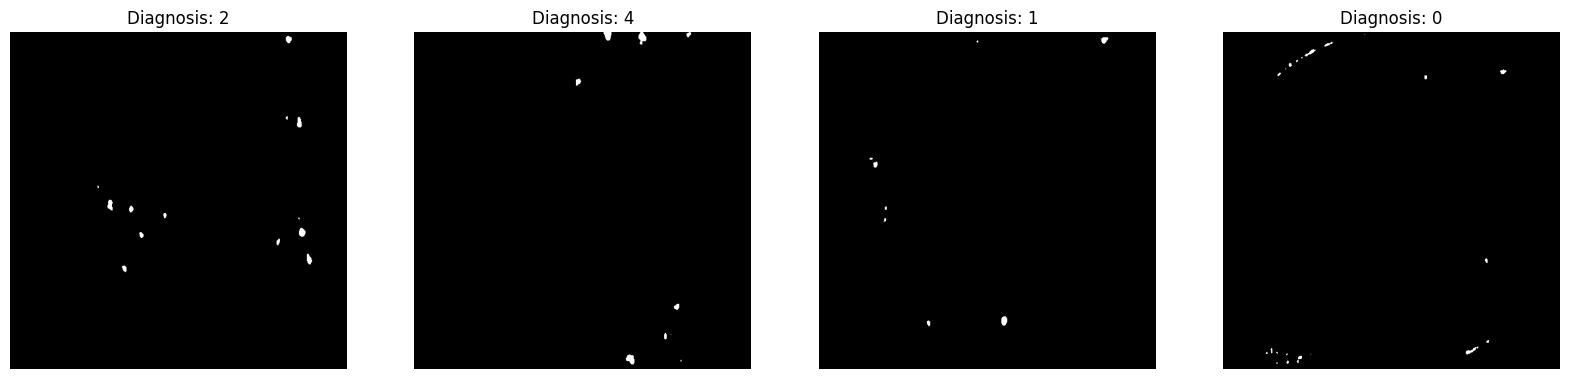

In [5]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title(f"Diagnosis: {y_train[i]}")
    plt.axis('off')
plt.show()

In [6]:
test_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/test.csv')

x_test = []
y_test = []

for index, row in test_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Haemorrhages/test_images/{row['id_code']}"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_test.append(image)
    y_test.append(row['diagnosis'])

x_test = np.array(x_test)
y_test = np.array(y_test, dtype=np.int32)

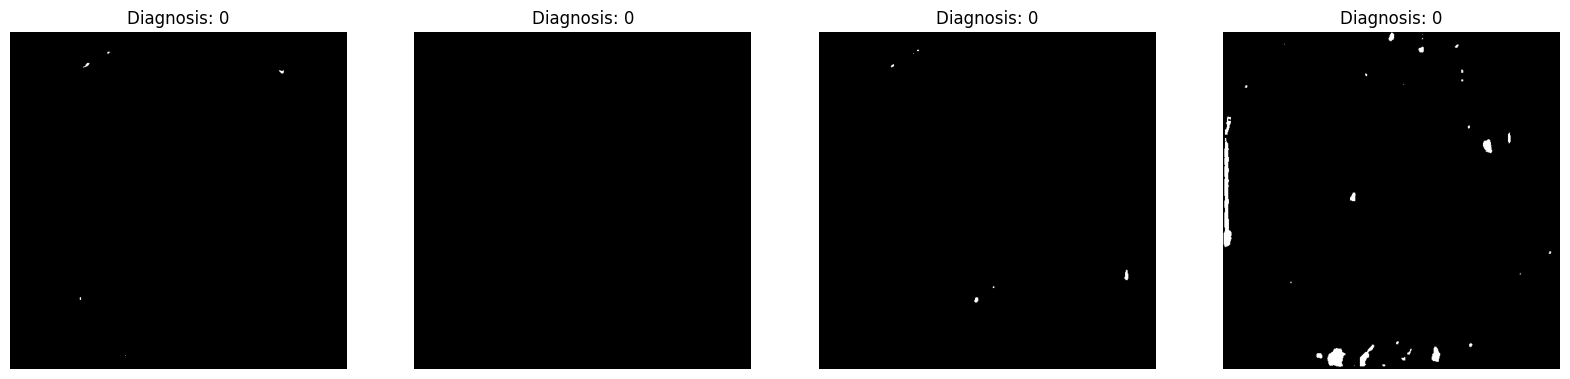

In [7]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_test[i],cmap='gray')
    plt.title(f"Diagnosis: {y_test[i]}")
    plt.axis('off')
plt.show()

In [8]:
y_train = np.where(y_train < 1, 0, 1)
y_test = np.where(y_test < 1, 0, 1)

In [9]:
x_train,y_train,x_val, y_val = split_data(x_train,y_train)
print('done')
print(x_train.shape,x_val.shape)

done
(2929, 512, 512) (733, 512, 512)


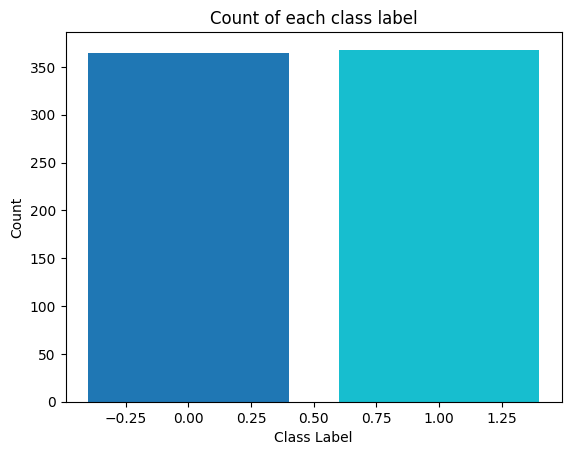

In [10]:
# Count the occurrences of each class label
unique_elements, counts = np.unique(y_val, return_counts=True)

# Plot the counts
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_elements)))
plt.bar(unique_elements, counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of each class label')
plt.show()

In [11]:
IMAGE_SIZE = (512,512)
EPOCHS = 25
BATCH_SIZE = 8
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('basic_model.keras', save_best_only=True, monitor='val_loss')

In [12]:
model_efficientnet_hae = efficientnet_model(IMAGE_SIZE)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model_efficientnet_hae_history =model_efficientnet_hae.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr,early_stopping,model_checkpoint]
)

Epoch 1/25


I0000 00:00:1716377356.965403     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716377357.122685     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7697 - loss: 0.5178

W0000 00:00:1716377540.430849     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 358s 541ms/step - accuracy: 0.7698 - loss: 0.5176 - val_accuracy: 0.4980 - val_loss: 0.7854 - learning_rate: 0.0010
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 277ms/step - accuracy: 0.8503 - loss: 0.3700 - val_accuracy: 0.7899 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 272ms/step - accuracy: 0.8742 - loss: 0.3161 - val_accuracy: 0.7135 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 272ms/step - accuracy: 0.9022 - loss: 0.2507 - val_accuracy: 0.8240 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 277ms/step - accuracy: 0.9093 - loss: 0.2382 - val_accuracy: 0.8417 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 272ms/step - accuracy: 0.9186 - loss: 0.2164 - val_accuracy: 0.7831 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 272ms/step - accuracy: 0.9182 

In [14]:
loss_efficientnet_hae, accuracy_efficientnet_hae = model_efficientnet_hae.evaluate(x_test, y_test)

print("Test Loss:", loss_efficientnet_hae)
print("Test Accuracy:", accuracy_efficientnet_hae)

37/37 ━━━━━━━━━━━━━━━━━━━━ 44s 680ms/step - accuracy: 0.6060 - loss: 0.9494
Test Loss: 1.2076694965362549
Test Accuracy: 0.5398305058479309


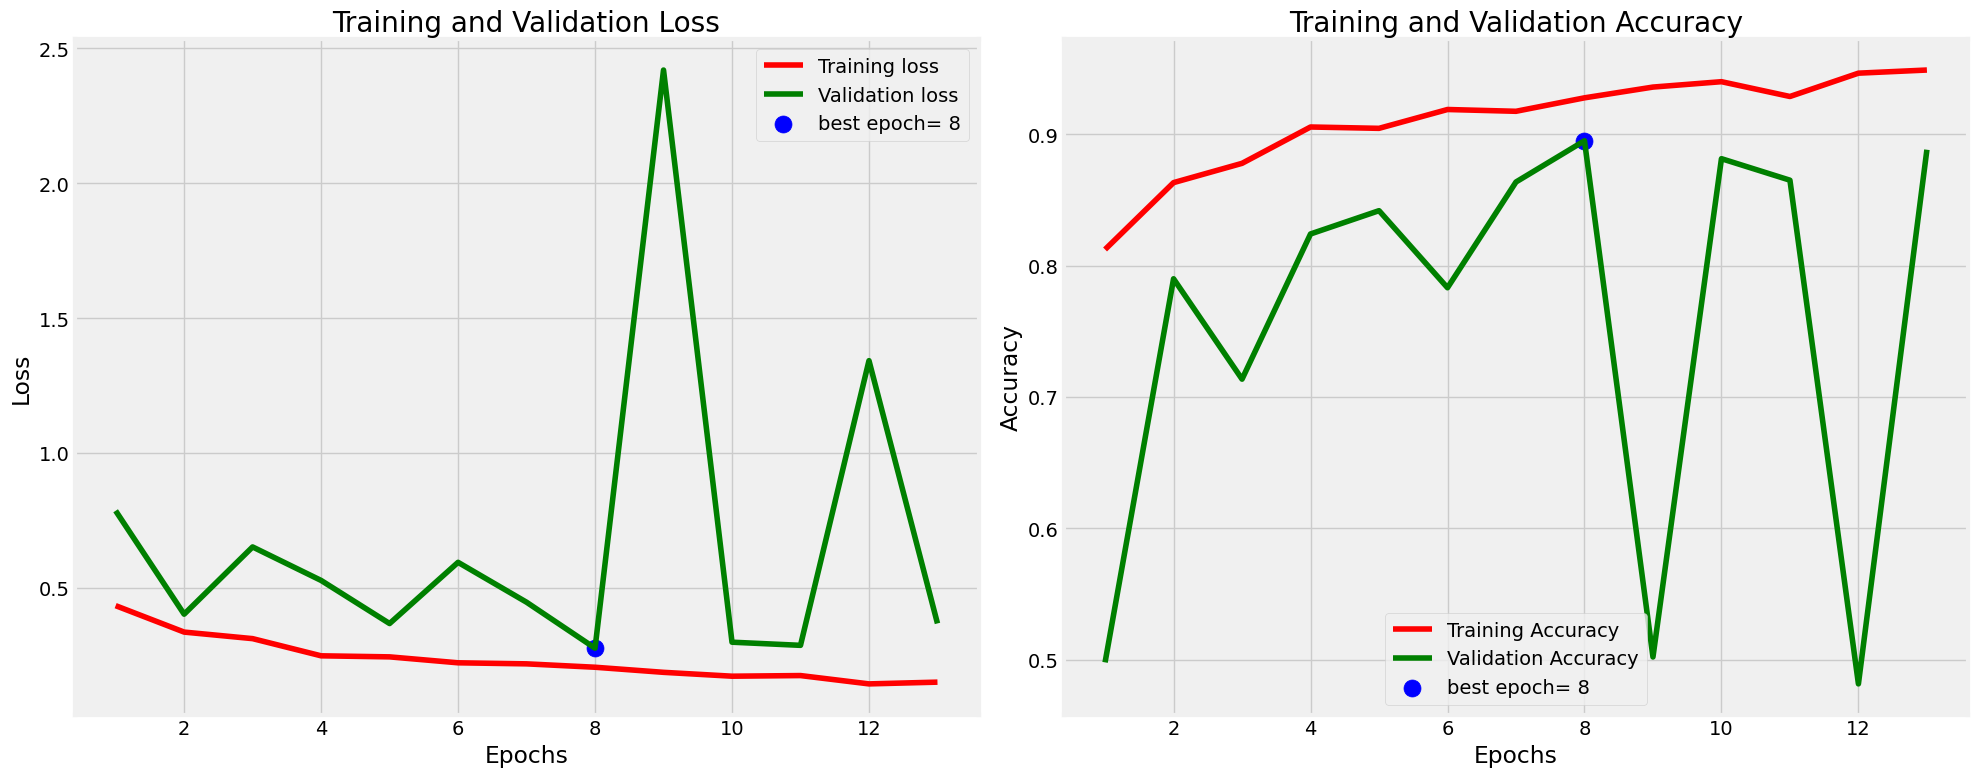

In [15]:
# Define needed variables
tr_acc = model_efficientnet_hae_history.history['accuracy']
tr_loss = model_efficientnet_hae_history.history['loss']
val_acc = model_efficientnet_hae_history.history['val_accuracy']
val_loss = model_efficientnet_hae_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step


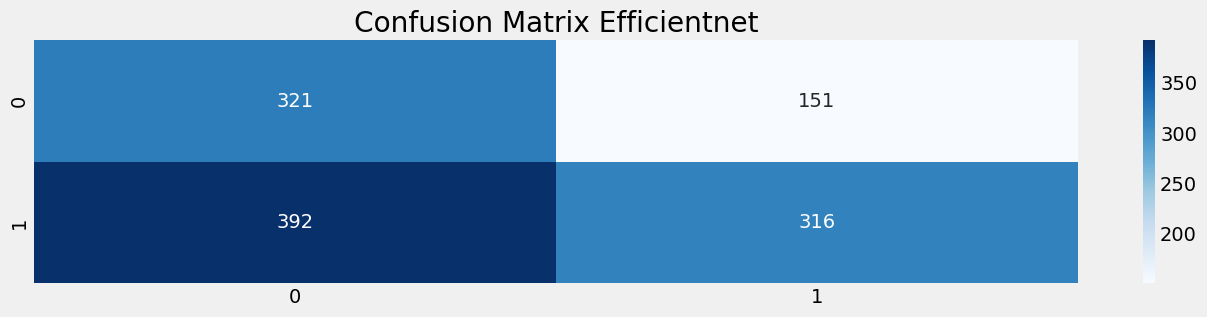

In [16]:
plt.figure(figsize=(15, 3))
y_pred_prob = model_efficientnet_hae.predict(x_test)
y_pred = np.round(y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Efficientnet')
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step


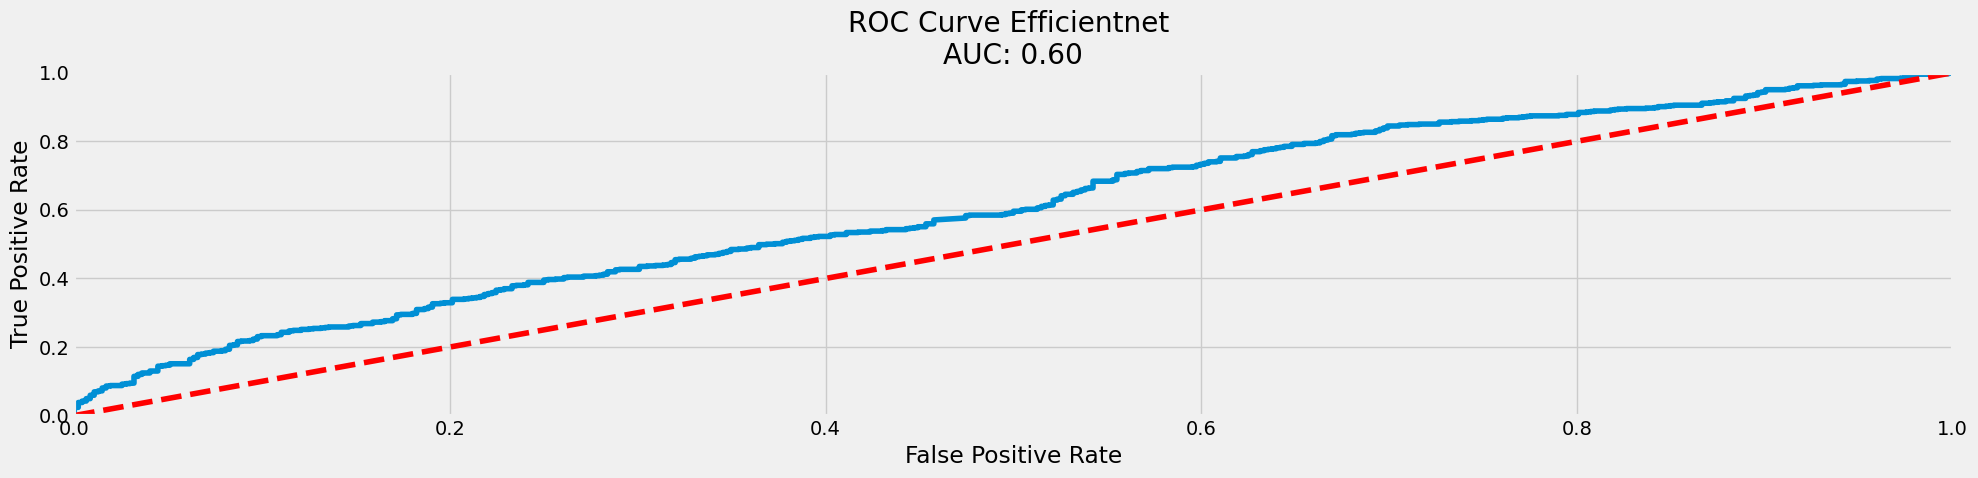

In [17]:
plt.figure(figsize=(20, 5))
y_pred_prob = model_efficientnet_hae.predict(x_test)
y_pred = np.round(y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  
plt.plot(fpr, tpr)
plt.title('ROC Curve Efficientnet \nAUC: {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


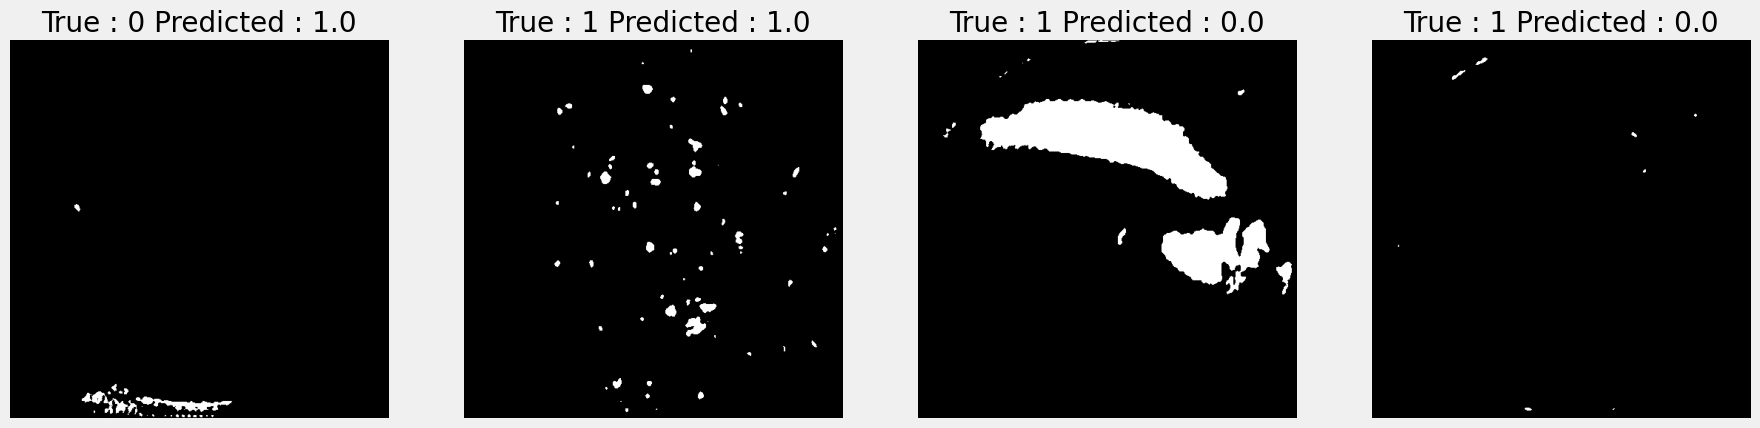

In [18]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    num = random.randint(0,x_test.shape[0])
    plt.imshow(x_test[num],cmap='gray')
    single_image = np.expand_dims(x_test[num], axis=0)
    y_pred = np.round(model_efficientnet_hae.predict(single_image)[0])
    plt.title(f"True : {y_test[num]} Predicted : {y_pred[0]}")
    plt.axis('off')
plt.show()

In [19]:
model_efficientnet_hae.save_weights('Haemorrhages_model.weights.h5')

<h1 id='hes'>Hard Exudates Segmentation</h1>

In [4]:
train_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/train.csv')

x_train = []
y_train = []

image_size = (512, 512)

for index, row in train_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Hard Exudates/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_train.append(image)
    y_train.append(row['diagnosis'])

x_train = np.array(x_train)
y_train = np.array(y_train, dtype=np.int32)

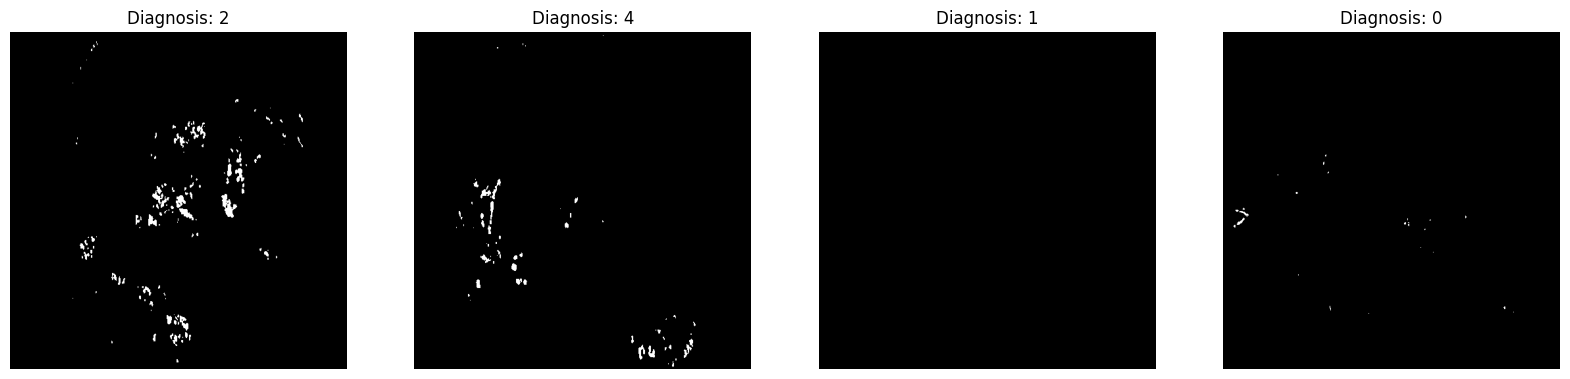

In [5]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title(f"Diagnosis: {y_train[i]}")
    plt.axis('off')
plt.show()

In [6]:
test_df = pd.read_csv('/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/test.csv')

x_test = []
y_test = []

for index, row in test_df.iterrows():
    image_path = f"/kaggle/input/aptos-2019-blindness-detection-segmented/APTOS 2019 Blindness Detection Segmented/Hard Exudates/test_images/{row['id_code']}"
    image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image = image/255
    x_test.append(image)
    y_test.append(row['diagnosis'])

x_test = np.array(x_test)
y_test = np.array(y_test, dtype=np.int32)

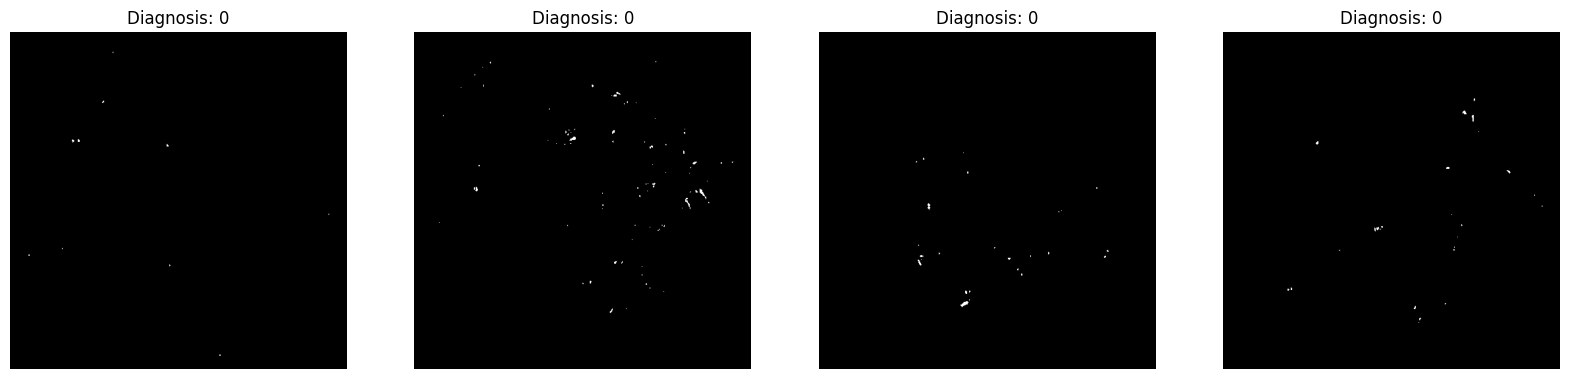

In [7]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_test[i],cmap='gray')
    plt.title(f"Diagnosis: {y_test[i]}")
    plt.axis('off')
plt.show()

In [8]:
y_train = np.where(y_train < 1, 0, 1)
y_test = np.where(y_test < 1, 0, 1)

In [9]:
x_train,y_train,x_val, y_val = split_data(x_train,y_train)
print('done')
print(x_train.shape,x_val.shape)

done
(2929, 512, 512) (733, 512, 512)


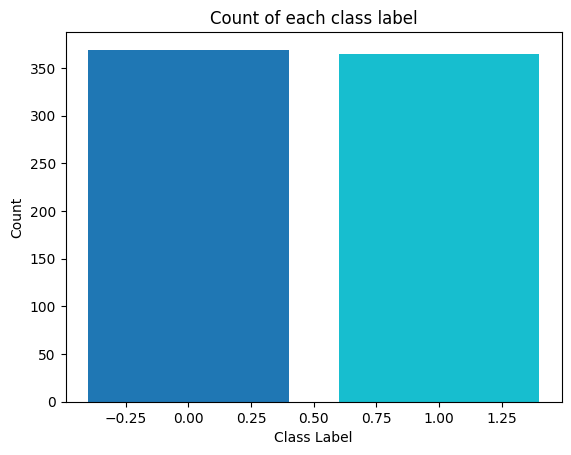

In [10]:
# Count the occurrences of each class label
unique_elements, counts = np.unique(y_val, return_counts=True)

# Plot the counts
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_elements)))
plt.bar(unique_elements, counts, color=colors)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of each class label')
plt.show()

In [11]:
IMAGE_SIZE = (512,512)
EPOCHS = 25
BATCH_SIZE = 8
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('basic_model.keras', save_best_only=True, monitor='val_loss')

In [12]:
model_efficientnet_hes = efficientnet_model(IMAGE_SIZE)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
model_efficientnet_hes_history =model_efficientnet_hes.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr,early_stopping,model_checkpoint]
)

Epoch 1/25


I0000 00:00:1716380085.124278     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716380085.298133     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7545 - loss: 0.5200

W0000 00:00:1716380285.240946     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 388s 589ms/step - accuracy: 0.7546 - loss: 0.5198 - val_accuracy: 0.5034 - val_loss: 0.7539 - learning_rate: 0.0010
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 273ms/step - accuracy: 0.8478 - loss: 0.3638 - val_accuracy: 0.5553 - val_loss: 0.7603 - learning_rate: 0.0010
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 278ms/step - accuracy: 0.8785 - loss: 0.3097 - val_accuracy: 0.9113 - val_loss: 0.2283 - learning_rate: 0.0010
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 273ms/step - accuracy: 0.8992 - loss: 0.2620 - val_accuracy: 0.6030 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 273ms/step - accuracy: 0.8927 - loss: 0.2773 - val_accuracy: 0.8813 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 273ms/step - accuracy: 0.9168 - loss: 0.2218 - val_accuracy: 0.8322 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 273ms/step - accuracy: 0.9210 

In [14]:
loss_efficientnet_hes, accuracy_efficientnet_hes = model_efficientnet_hes.evaluate(x_test, y_test)

print("Test Loss:", loss_efficientnet_hes)
print("Test Accuracy:", accuracy_efficientnet_hes)

37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 700ms/step - accuracy: 0.6027 - loss: 1.9969
Test Loss: 2.603571653366089
Test Accuracy: 0.4864406883716583


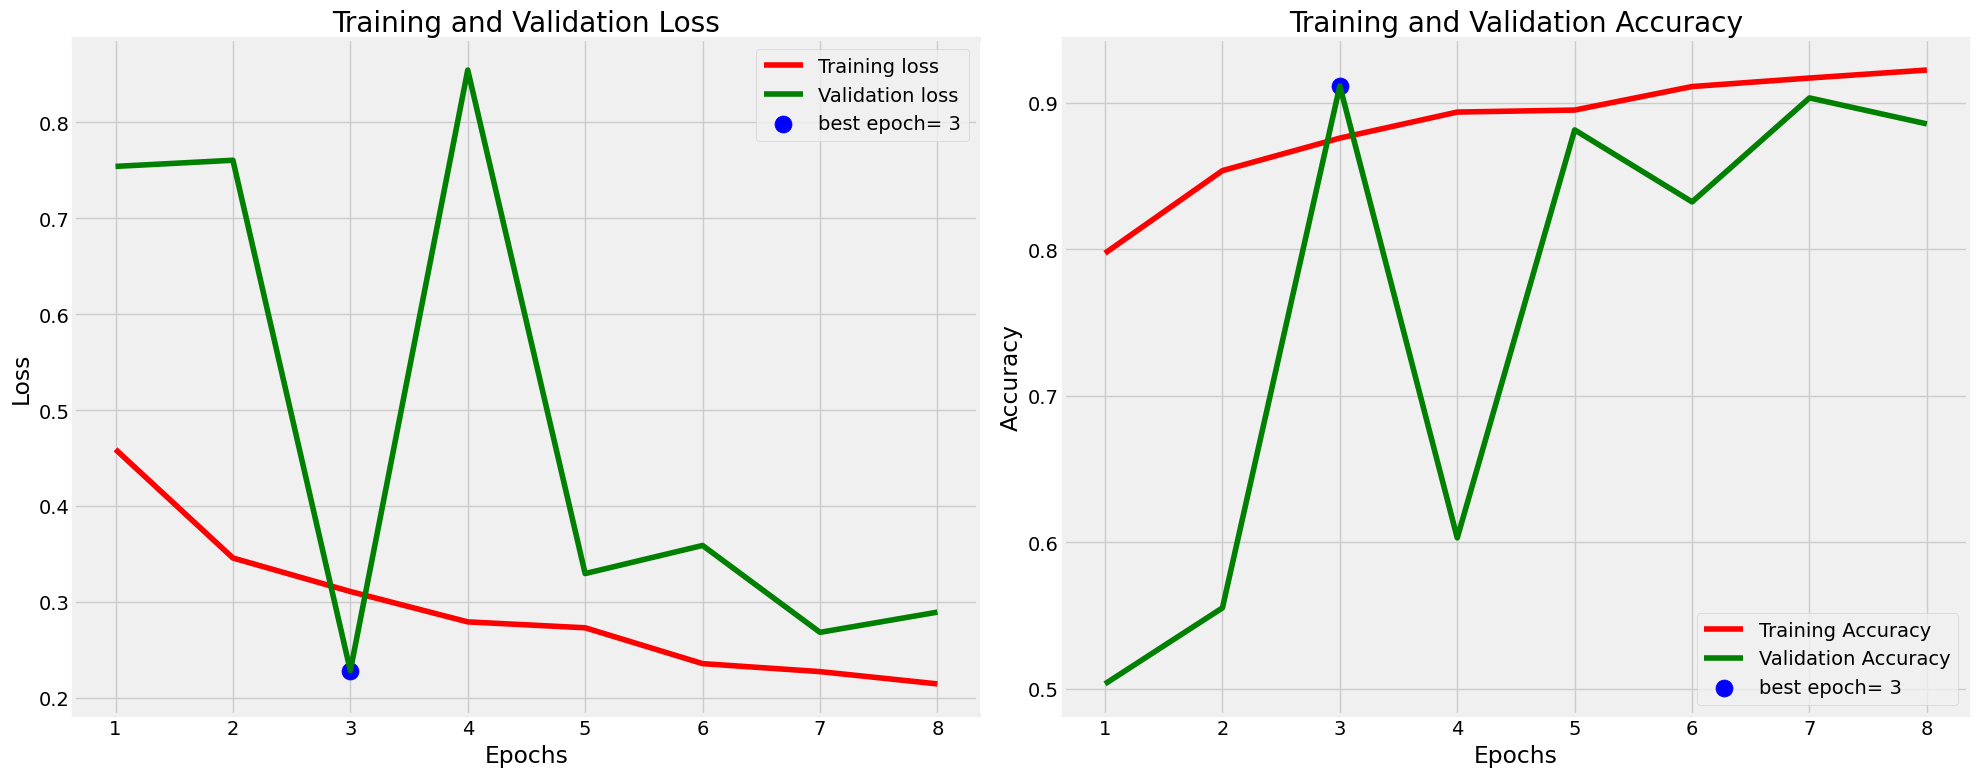

In [15]:
# Define needed variables
tr_acc = model_efficientnet_hes_history.history['accuracy']
tr_loss = model_efficientnet_hes_history.history['loss']
val_acc = model_efficientnet_hes_history.history['val_accuracy']
val_loss = model_efficientnet_hes_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step


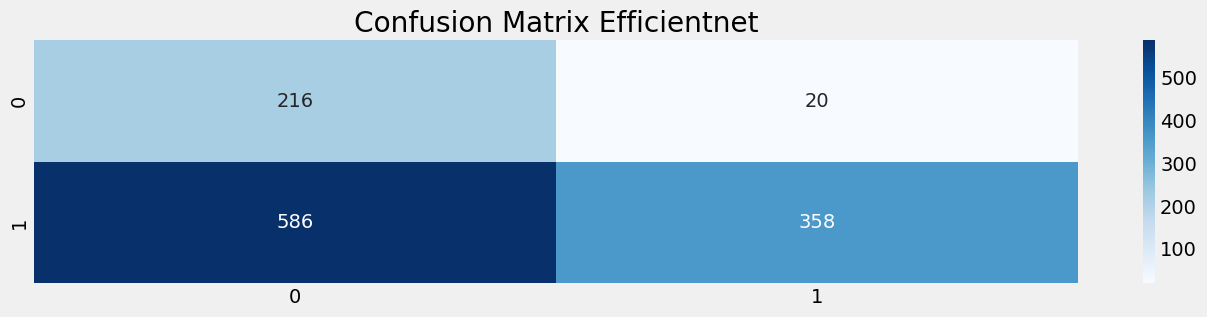

In [16]:
plt.figure(figsize=(15, 3))
y_pred_prob = model_efficientnet_hes.predict(x_test)
y_pred = np.round(y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Efficientnet')
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step


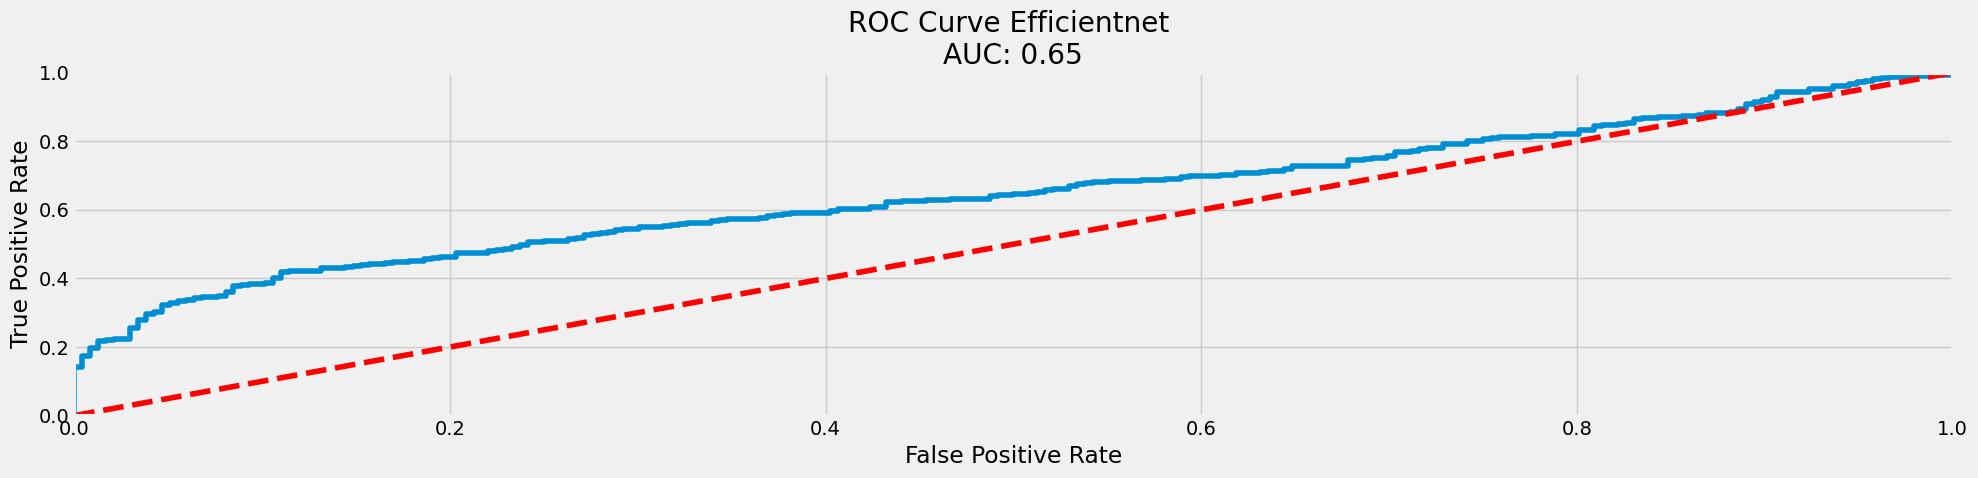

In [17]:
plt.figure(figsize=(20, 5))
y_pred_prob = model_efficientnet_hes.predict(x_test)
y_pred = np.round(y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)  
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  
plt.plot(fpr, tpr)
plt.title('ROC Curve Efficientnet \nAUC: {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


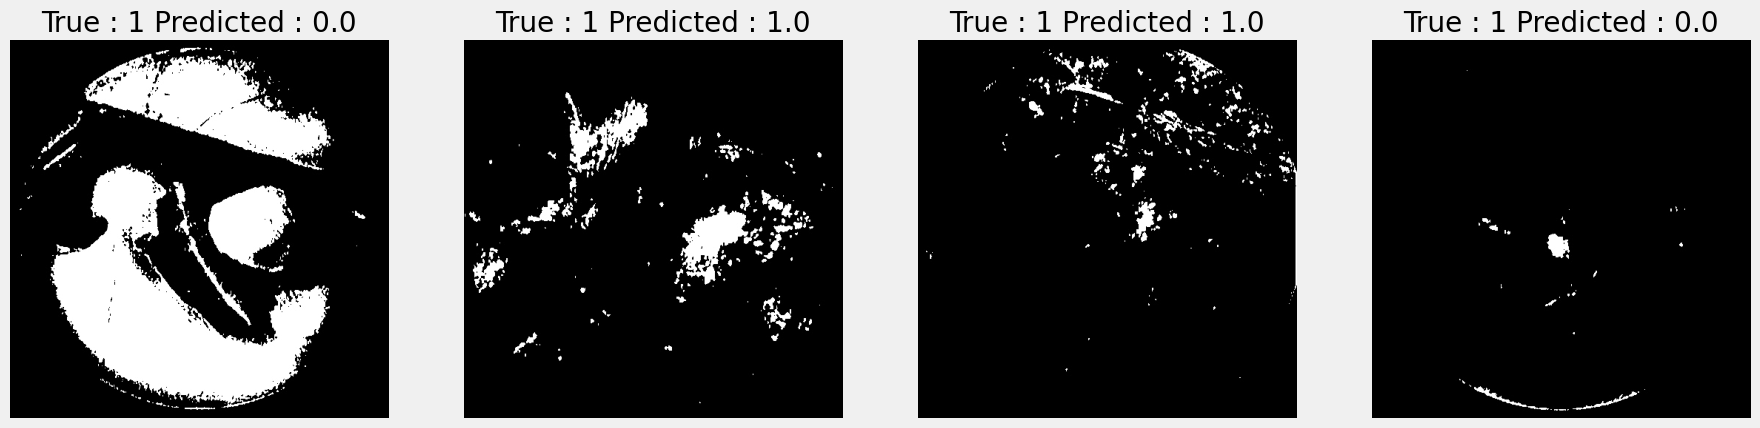

In [18]:
# Plot some of the images
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1,4,i+1)
    num = random.randint(0,x_test.shape[0])
    plt.imshow(x_test[num],cmap='gray')
    single_image = np.expand_dims(x_test[num], axis=0)
    y_pred = np.round(model_efficientnet_hes.predict(single_image)[0])
    plt.title(f"True : {y_test[num]} Predicted : {y_pred[0]}")
    plt.axis('off')
plt.show()